In [1]:
#Group Project Script
#Ethan Fischbein


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType
from pyspark.sql.functions import to_timestamp, upper, col

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession.builder.appName('ZillowPrices').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g'), ('spark.sql.repl.eagerEval.enabled', True)])


In [4]:
#SECTION 1 - Load base CSV file & analyze
df = spark.read.csv("/user/efischbein/data/group_project/us_housing_prices", inferSchema=True, header=True)

In [5]:
df.describe()

DataFrame[summary: string, state: string, zip5: string, physical_address: string, city: string, county: string, property_id: string, sale_date: string, property_type: string, sale_price: string, seller_name: string, buyer_name: string, num_units: string, year_built: string, source_url: string, book: string, page: string]

In [6]:
df.show(3)

+-----+-----+-----------------+-------+---------+-----------+--------------------+--------------------+----------+-----------+----------+---------+----------+--------------------+----+----+
|state| zip5| physical_address|   city|   county|property_id|           sale_date|       property_type|sale_price|seller_name|buyer_name|num_units|year_built|          source_url|book|page|
+-----+-----+-----------------+-------+---------+-----------+--------------------+--------------------+----------+-----------+----------+---------+----------+--------------------+----+----+
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE|  408144009|1988-05-25 00:00:...|SINGLE FAMILY DWE...|         0|       null|      null|        1|      1965|https://ca-rivers...|null|null|
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE|  408144009|1989-03-17 00:00:...|SINGLE FAMILY DWE...|         0|       null|      null|        1|      1965|https://ca-rivers...|null|null|
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE| 

In [7]:
df.dtypes

[('state', 'string'),
 ('zip5', 'string'),
 ('physical_address', 'string'),
 ('city', 'string'),
 ('county', 'string'),
 ('property_id', 'string'),
 ('sale_date', 'string'),
 ('property_type', 'string'),
 ('sale_price', 'string'),
 ('seller_name', 'string'),
 ('buyer_name', 'string'),
 ('num_units', 'string'),
 ('year_built', 'string'),
 ('source_url', 'string'),
 ('book', 'string'),
 ('page', 'string')]

In [8]:
#SECTION 2 - Data Cleanup
#1. drop extra columns (seller_name, buyer_name, source_url, book, page)
#2. Dates - limited from 1970-2021
#3. Sale Price - not null, greater than 0
#4. City, State - remove null
#5. Num. Units -  must be 1
#6. Property Type - remove condos, mobile homes
#7. Num. Sales - must be greater than 1

In [9]:
#Data Cleanup - drop extra columns
df = df.drop("seller_name", "buyer_name", "source_url", "book", "page")

In [10]:
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

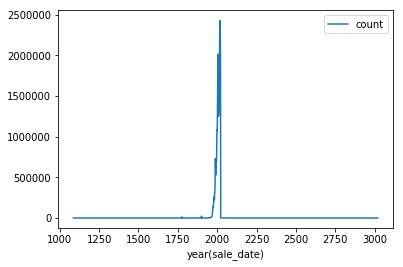

In [11]:
#home sales by year
sale_plt = df.groupBy(F.year(col('sale_date'))).count().toPandas()
sale_plt = sale_plt.sort_values('year(sale_date)')
sale_plt = sale_plt.set_index('year(sale_date)')
sale_plt.plot(kind ='line')
plt.show()

In [12]:
#Data Cleanup - Dates: 1970 - 2021
df = df.withColumn('sale_date', F.to_date(F.unix_timestamp('sale_date', 'yyyy-MM-dd').cast('timestamp')))
df = df.filter((F.year(col("sale_date"))<=2021) & (F.year(col("sale_date"))>=1970))
df.select('sale_date').head(5)

[Row(sale_date=datetime.date(1988, 5, 25)),
 Row(sale_date=datetime.date(1989, 3, 17)),
 Row(sale_date=datetime.date(1991, 6, 18)),
 Row(sale_date=datetime.date(1994, 12, 12)),
 Row(sale_date=datetime.date(2003, 2, 28))]

In [13]:
#Data Cleanup - Sale Price
df = df.withColumn('sale_price', df.sale_price.cast('float'))
df = df.filter(col("sale_price").isNotNull()).filter(col("sale_price")>0)
df.select('sale_price').head(5)

[Row(sale_price=59000.0),
 Row(sale_price=280000.0),
 Row(sale_price=381591.0),
 Row(sale_price=592000.0),
 Row(sale_price=585000.0)]

In [14]:
df.describe("sale_date", "sale_price").show()

+-------+-----------------+
|summary|       sale_price|
+-------+-----------------+
|  count|         42865931|
|   mean|493120.9679655622|
| stddev|6699651.508783258|
|    min|              1.0|
|    max|            8.2E9|
+-------+-----------------+



In [15]:
#Data Cleanup - remove null cities & states
df = df.filter((col("city").isNotNull()) & (col("state").isNotNull()) & (col("physical_address").isNotNull()) & (col("zip5").isNotNull()))

In [16]:
#top cities
df.groupBy('city','state').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+-------+
|                city|state|  count|
+--------------------+-----+-------+
|         LOS ANGELES|   CA|1403176|
|       NEW YORK CITY|   NY|1260613|
|               TAMPA|   FL|1074407|
|        PHILADELPHIA|   PA| 738332|
|            LAKELAND|   FL| 542238|
|             SEATTLE|   WA| 413323|
|      VIRGINIA BEACH|   VA| 365435|
|        INDIANAPOLIS|   IN| 329493|
|           DAVENPORT|   FL| 306982|
|UNINCORPORATED CO...|   FL| 303591|
+--------------------+-----+-------+
only showing top 10 rows



In [17]:
#Data Cleanup - View number of units, want to only be 1
df = df.filter(col('num_units')==1)
df.groupBy('num_units').count().orderBy('count', ascending=False).show()

+---------+-------+
|num_units|  count|
+---------+-------+
|        1|9742796|
+---------+-------+



In [18]:
#view property types
df.groupBy('property_type').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|       property_type|  count|
+--------------------+-------+
|SINGLE FAMILY RES...|2579548|
|                null|2104659|
|SINGLE FAMILY DWE...|1402975|
|         CONDOMINIUM| 784499|
|SINGLE FAMILY/SFR...| 440753|
|       SINGLE FAMILY| 421979|
|          ONE FAMILY| 301540|
|     SINGLE FAMILY R| 297952|
|       SINGLE-FAMILY| 179918|
|RESIDENTIAL < 10 ...| 158199|
|13  CONDOS - ELEV...| 148473|
|MULTI-FAMILY RESI...| 137634|
|01  ONE FAMILY HOMES| 126917|
|MOBILE HOME/MANUF...|  96049|
|13 CONDOS - ELEVA...|  83340|
|01 ONE FAMILY DWE...|  62157|
|01  ONE FAMILY DW...|  46209|
|      CONDO/TOWNHOME|  43164|
|ATTACHED HOUSING/...|  24802|
|28  COMMERCIAL CO...|  24360|
+--------------------+-------+
only showing top 20 rows



In [19]:
#Data Cleanup - filter out condos, mobile homes, rentals
df = df.where(~ col("property_type").like("%CONDO%"))
df = df.where(~ col("property_type").like("%MOBILE%HOME%"))
df = df.where(~ col("property_type").like("%RENTALS%"))

In [20]:
#view top properties
df.groupBy('city','state', 'physical_address', 'zip5', 'property_type').count().orderBy('count', ascending=False).show(25)

+------------+-----+--------------------+-----+--------------------+-----+
|        city|state|    physical_address| zip5|       property_type|count|
+------------+-----+--------------------+-----+--------------------+-----+
|PALM SPRINGS|   CA|  1800 S SUNRISE WAY|92264|SINGLE FAMILY DWE...|  106|
|PHILADELPHIA|   PA|   2018-32 WALNUT ST|19103|       SINGLE FAMILY|  102|
|  LONG BEACH|   CA|        225 W 6TH ST|90802|SINGLE FAMILY RES...|   97|
|PHILADELPHIA|   PA|        112 N 2ND ST|19106|       SINGLE FAMILY|   93|
|    LAKELAND|   FL|  2020 EDGEWOOD DR E|33803|ATTACHED HOUSING/...|   91|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33898|SINGLE FAMILY/SFR...|   86|
|PHILADELPHIA|   PA|224-30 W RITTENHO...|19103|       SINGLE FAMILY|   81|
|  LAKE WALES|   FL|   2285 BOY SCOUT RD|33853|SINGLE FAMILY/MUL...|   70|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33853|SINGLE FAMILY/SFR...|   62|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33898|SINGLE FAMILY/RES...|   61|
|PHILADELPHIA|   PA|2401 

In [21]:
from pyspark.sql.functions import rank
from pyspark.sql.window import Window

In [22]:
#Data Cleanup - filter dataframe based on window function to only show properties with only 1 sale
windowSpec = Window().partitionBy(['city','state', 'physical_address', 'zip5']).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("num_sales", F.count(col('city')).over(windowSpec)).filter(col('num_sales') > 1)

In [23]:
#SECTION 3 - Join Predictive Data Features

In [24]:
#SECTION 3a - Public Schools data

In [25]:
#Public_Schools.csv
Public_Schools = spark.read.csv("/user/efischbein/data/group_project/Public_Schools.csv", inferSchema=True, header=True)

In [26]:
Public_Schools.describe()

DataFrame[summary: string, X: string, Y: string, OBJECTID: string, NCESID: string, NAME: string, ADDRESS: string, CITY: string, STATE: string, ZIP: string, ZIP4: string, TELEPHONE: string, TYPE: string, STATUS: string, POPULATION: string, COUNTY: string, COUNTYFIPS: string, COUNTRY: string, LATITUDE: string, LONGITUDE: string, NAICS_CODE: string, NAICS_DESC: string, SOURCE: string, SOURCEDATE: string, VAL_METHOD: string, VAL_DATE: string, WEBSITE: string, LEVEL_: string, ENROLLMENT: string, ST_GRADE: string, END_GRADE: string, DISTRICTID: string, FT_TEACHER: string, SHELTER_ID: string]

In [27]:
Public_Schools.dtypes
#Can maybe use the count of schools by city as a predictor? But would be correlated with city size

[('X', 'double'),
 ('Y', 'double'),
 ('OBJECTID', 'int'),
 ('NCESID', 'bigint'),
 ('NAME', 'string'),
 ('ADDRESS', 'string'),
 ('CITY', 'string'),
 ('STATE', 'string'),
 ('ZIP', 'string'),
 ('ZIP4', 'string'),
 ('TELEPHONE', 'string'),
 ('TYPE', 'string'),
 ('STATUS', 'int'),
 ('POPULATION', 'int'),
 ('COUNTY', 'string'),
 ('COUNTYFIPS', 'string'),
 ('COUNTRY', 'string'),
 ('LATITUDE', 'string'),
 ('LONGITUDE', 'double'),
 ('NAICS_CODE', 'double'),
 ('NAICS_DESC', 'string'),
 ('SOURCE', 'string'),
 ('SOURCEDATE', 'string'),
 ('VAL_METHOD', 'string'),
 ('VAL_DATE', 'string'),
 ('WEBSITE', 'string'),
 ('LEVEL_', 'string'),
 ('ENROLLMENT', 'int'),
 ('ST_GRADE', 'string'),
 ('END_GRADE', 'string'),
 ('DISTRICTID', 'int'),
 ('FT_TEACHER', 'int'),
 ('SHELTER_ID', 'string')]

In [28]:
#Public schools - First predictor variable - raw count by zip code
num_schools_zip = Public_Schools.groupby('ZIP').count()
num_schools_zip

DataFrame[ZIP: string, count: bigint]

In [29]:
#join predictor to base table
df = df.join(num_schools_zip, df['zip5'] == num_schools_zip['ZIP'], 'left').\
    select(df["*"],num_schools_zip["count"]).na.fill(0)

In [30]:
df = df.withColumnRenamed('count','zip_num_schools')
df.show(5)

+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+
|state| zip5|    physical_address| city|     county|property_id| sale_date|       property_type|sale_price|num_units|year_built|num_sales|zip_num_schools|
+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2002-01-10|SINGLE FAMILY RES...| 7303573.0|        1|      2003|        3|              5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2003-09-17|SINGLE FAMILY RES...|  458000.0|        1|      2003|        3|              5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2012-08-02|SINGLE FAMILY RES...|  399003.0|        1|      2003|        3|              5|
|   CA|93510|1940 SHADOW CANYO...|ACTON|LOS ANGELES| 3056032042|1991-0

In [31]:
#Public schools - Second predictor variable - number of schools by city
num_schools_city = Public_Schools.groupby('city', 'state').count()
num_schools_city

DataFrame[city: string, state: string, count: bigint]

In [32]:
#join predictor to base table
df = df.join(num_schools_city, (df['city'] == num_schools_city['city']) & \
             (df['state'] == num_schools_city['state']), 'left').\
             select(df["*"],num_schools_city["count"]).na.fill(0)

In [33]:
df = df.withColumnRenamed('count','city_num_schools')
df.show(5)

+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+----------------+
|state| zip5|    physical_address| city|     county|property_id| sale_date|       property_type|sale_price|num_units|year_built|num_sales|zip_num_schools|city_num_schools|
+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+----------------+
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2002-01-10|SINGLE FAMILY RES...| 7303573.0|        1|      2003|        3|              5|               5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2003-09-17|SINGLE FAMILY RES...|  458000.0|        1|      2003|        3|              5|               5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2012-08-02|SINGLE FAMILY RES...|  399003.0|        1|      2003|        3|  

In [34]:
#Public schools - Third predictor variable - Student Teacher Ratio by Zip
st_ratio_zip = Public_Schools.filter((col('ENROLLMENT') != -1) & (col('FT_TEACHER') != -1))
st_ratio_zip = st_ratio_zip.groupby('ZIP').agg((F.sum(st_ratio_zip.ENROLLMENT) / F.sum(st_ratio_zip.FT_TEACHER)).alias('zip_st_ratio'))
st_ratio_zip.show(5, vertical=True)

-RECORD 0--------------------------
 ZIP          | 65548              
 zip_st_ratio | 12.702380952380953 
-RECORD 1--------------------------
 ZIP          | 55321              
 zip_st_ratio | 16.787610619469028 
-RECORD 2--------------------------
 ZIP          | 28675              
 zip_st_ratio | 12.768292682926829 
-RECORD 3--------------------------
 ZIP          | 80305              
 zip_st_ratio | 20.45909090909091  
-RECORD 4--------------------------
 ZIP          | 56315              
 zip_st_ratio | 13.333333333333334 
only showing top 5 rows



In [35]:
#join predictor to base table
df = df.join(st_ratio_zip, df['zip5'] == st_ratio_zip['ZIP'], 'left').\
    select(df["*"],st_ratio_zip["zip_st_ratio"])

In [36]:
#Public schools - Fourth predictor variable - Student Teacher Ratio by City
st_ratio_city = Public_Schools.filter((col('ENROLLMENT') != -1) & (col('FT_TEACHER') != -1))
st_ratio_city = st_ratio_city.groupby('city', 'state').agg((F.sum(st_ratio_city.ENROLLMENT) / F.sum(st_ratio_city.FT_TEACHER)).alias('city_st_ratio'))
st_ratio_city.show(5, vertical=True)

-RECORD 0---------------------------
 city          | STATEN ISLAND      
 state         | NY                 
 city_st_ratio | 14.711904202864522 
-RECORD 1---------------------------
 city          | GODDARD            
 state         | KS                 
 city_st_ratio | 16.900302114803626 
-RECORD 2---------------------------
 city          | COOKEVILLE         
 state         | TN                 
 city_st_ratio | 17.303964757709252 
-RECORD 3---------------------------
 city          | FAIRFIELD          
 state         | CA                 
 city_st_ratio | 23.687432867883995 
-RECORD 4---------------------------
 city          | FREDERICK          
 state         | PA                 
 city_st_ratio | 17.568181818181817 
only showing top 5 rows



In [37]:
#join predictor to base table
df = df.join(st_ratio_city, (df['city'] == st_ratio_city['city']) & \
             (df['state'] == st_ratio_city['state']), 'left').\
             select(df["*"],st_ratio_city["city_st_ratio"]).na.fill(0)

In [38]:
df.show(10, vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002    

In [39]:
#SECTION 3b - Housing CPI
#Limitations, not specific to regions

In [40]:
#CPI
CPI = spark.read.csv("/user/efischbein/data/group_project/CPIHOSNS.csv", inferSchema=True, header=True)

In [41]:
CPI.dtypes

[('DATE', 'timestamp'), ('CPIHOSNS', 'double')]

In [42]:
CPI = CPI.withColumn('month', F.month(col('DATE')))
CPI = CPI.withColumn('year', F.year(col('DATE')))
CPI.show(5)

+-------------------+--------+-----+----+
|               DATE|CPIHOSNS|month|year|
+-------------------+--------+-----+----+
|1967-01-01 00:00:00|    30.5|    1|1967|
|1967-02-01 00:00:00|    30.5|    2|1967|
|1967-03-01 00:00:00|    30.5|    3|1967|
|1967-04-01 00:00:00|    30.6|    4|1967|
|1967-05-01 00:00:00|    30.7|    5|1967|
+-------------------+--------+-----+----+
only showing top 5 rows



In [43]:
#join predictor to base table
df = df.join(CPI, (F.month(df['sale_date']) == CPI['month']) & \
             (F.year(df['sale_date']) == CPI['year']), 'left').\
             select(df["*"],CPI["CPIHOSNS"])

In [44]:
df.show(10, vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES   

In [45]:
#SECTION 3c - ZVHI
#Limitations, not all regions included, will leave as 0

In [48]:
#ZVHI
ZVHI = spark.read.csv("/user/efischbein/data/group_project/ZHVI_cln.csv", inferSchema=True, header=True)
ZVHI.head(5)

[Row(Date='1/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127090),
 Row(Date='2/29/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127434),
 Row(Date='3/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127795),
 Row(Date='4/30/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=128532),
 Row(Date='5/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=129274)]

In [49]:
ZVHI = ZVHI.withColumn('Date', F.to_date(F.unix_timestamp('Date', 'MM/dd/yyyy').cast('timestamp')))
ZVHI.select('Date').head(5)

[Row(Date=datetime.date(2000, 1, 31)),
 Row(Date=datetime.date(2000, 2, 29)),
 Row(Date=datetime.date(2000, 3, 31)),
 Row(Date=datetime.date(2000, 4, 30)),
 Row(Date=datetime.date(2000, 5, 31))]

In [50]:
ZVHI.dtypes
#time series; could be useful to pivot, but seems redundant to the city index CSV

[('Date', 'date'),
 ('RegionID', 'int'),
 ('SizeRank', 'int'),
 ('RegionName', 'string'),
 ('RegionType', 'string'),
 ('StateName', 'string'),
 ('ZVHI', 'int')]

In [51]:
#filter out nationwide records
ZVHI = ZVHI.filter((ZVHI['RegionType'] == 'Msa') & (ZVHI['ZVHI'] > 0)) \
    .groupBy('StateName', 'Date').agg(F.mean(col('ZVHI')) \
    .alias('ZVHI')).orderBy('StateName', 'Date')

In [52]:
#add month, year columns
ZVHI = ZVHI.withColumn('month', F.month(col('DATE')))
ZVHI = ZVHI.withColumn('year', F.year(col('DATE')))

In [53]:
#ZVHI - join on city name
df = df.join(ZVHI, \
             (F.month(df['sale_date']) == ZVHI['month']) & (F.year(df['sale_date']) == ZVHI['year']) \
             & (df['state'] == ZVHI['StateName']), 'left').na.fill(0)
df.show(5,vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
 StateName        | CA                   
 Date             | 2002-01-31           
 ZVHI             | 261132.8076923077    
 month            | 1                    
 year             | 2002                 
-RECORD 1-------------------------

In [54]:
#SECTION 3d - Income

In [55]:
#Income
Income = spark.read.csv("/user/efischbein/data/group_project/Census_Income", inferSchema=True, header=True)

In [56]:
Income.show(5, vertical = True)

-RECORD 0-----------------------------------------------------------------------------------------------------------
 Year                                                                                              | 2011           
 id                                                                                                | 8600000US00601 
 Geographic Area Name                                                                              | ZCTA5 00601    
 Households!!Estimate!!Total                                                                       | 5210           
 Households!!Margin of Error!!Total                                                                | 212            
 Households!!Estimate!!Less than $10,000                                                           | 42.8           
 Households!!Margin of Error!!Less than $10,000                                                    | 3.9            
 Households!!Estimate!!$10,000 to $14,999                       

In [57]:
#limit columns
income_df = Income.select('Year', 'Geographic Area Name', 'Households!!Estimate!!Median income (dollars)')
income_df.show(5, vertical=True)

-RECORD 0----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00601 
 Households!!Estimate!!Median income (dollars) | 13318       
-RECORD 1----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00602 
 Households!!Estimate!!Median income (dollars) | 14947       
-RECORD 2----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00603 
 Households!!Estimate!!Median income (dollars) | 14437       
-RECORD 3----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00606 
 Households!!Estimate!!Median income (dollars) | 11155       
-RECORD 

In [58]:
#verify years
income_df.select('Year').distinct().orderBy('year').show()

+----+
|Year|
+----+
|2011|
|2012|
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
|2019|
+----+



In [59]:
#clean zip column
income_df = income_df.withColumn('Zip', F.substring(col('Geographic Area Name'), -5, 5))
income_df.show(5,vertical=True)

-RECORD 0----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00601 
 Households!!Estimate!!Median income (dollars) | 13318       
 Zip                                           | 00601       
-RECORD 1----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00602 
 Households!!Estimate!!Median income (dollars) | 14947       
 Zip                                           | 00602       
-RECORD 2----------------------------------------------------
 Year                                          | 2011        
 Geographic Area Name                          | ZCTA5 00603 
 Households!!Estimate!!Median income (dollars) | 14437       
 Zip                                           | 00603       
-RECORD 3----------------------------------------------------
 Year   

In [60]:
#Income - join on city name
df = df.join(income_df, \
             (F.year(df['sale_date']) == income_df['Year']) & (df['zip5'] == income_df['Zip']), 'left')
df.show(5,vertical=True)

-RECORD 0-------------------------------------------------------------
 state                                         | CA                   
 zip5                                          | 93510                
 physical_address                              | 1629 MARY RD         
 city                                          | ACTON                
 county                                        | LOS ANGELES          
 property_id                                   | 3057028002           
 sale_date                                     | 2002-01-10           
 property_type                                 | SINGLE FAMILY RES... 
 sale_price                                    | 7303573.0            
 num_units                                     | 1                    
 year_built                                    | 2003                 
 num_sales                                     | 3                    
 zip_num_schools                               | 5                    
 city_

In [61]:
#Income
pre_2000 = spark.read.csv("/user/efischbein/data/group_project/county_pre_2000_data_cln.csv", header=True)
pre_2000.show(5, vertical=True)

-RECORD 0---------------
 Region | United States 
 Year   | 1969          
 Income | 8486          
-RECORD 1---------------
 Region | United States 
 Year   | 1970          
 Income | 8486          
-RECORD 2---------------
 Region | United States 
 Year   | 1971          
 Income | 8486          
-RECORD 3---------------
 Region | United States 
 Year   | 1972          
 Income | 8486          
-RECORD 4---------------
 Region | United States 
 Year   | 1973          
 Income | 8486          
only showing top 5 rows



In [62]:
pre_2000 = pre_2000.filter(col('Region').contains('County'))
pre_2000 = pre_2000.withColumn('County', F.upper(F.substring_index(col('Region'), ' County', 1)))
pre_2000.show(5)

+------------------+----+------+-------+
|            Region|Year|Income| County|
+------------------+----+------+-------+
|Autauga County, AL|1969|  6808|AUTAUGA|
|Autauga County, AL|1970|  6808|AUTAUGA|
|Autauga County, AL|1971|  6808|AUTAUGA|
|Autauga County, AL|1972|  6808|AUTAUGA|
|Autauga County, AL|1973|  6808|AUTAUGA|
+------------------+----+------+-------+
only showing top 5 rows



In [63]:
#pre_2000 - join on county name
df = df.join(pre_2000, \
             (F.year(df['sale_date']) == pre_2000['Year']) \
             & (F.upper(df['county']) == F.upper(pre_2000['County'])), 'left').na.fill(0)
df.show(5,vertical=True)

-RECORD 0-------------------------------------------------------------
 state                                         | CA                   
 zip5                                          | 93510                
 physical_address                              | 1629 MARY RD         
 city                                          | ACTON                
 county                                        | LOS ANGELES          
 property_id                                   | 3057028002           
 sale_date                                     | 2002-01-10           
 property_type                                 | SINGLE FAMILY RES... 
 sale_price                                    | 7303573.0            
 num_units                                     | 1                    
 year_built                                    | 2003                 
 num_sales                                     | 3                    
 zip_num_schools                               | 5                    
 city_

In [64]:
#create final income field combining the datasets
df = df.withColumn('Median_Income', F.when(F.year(col('sale_date')) < 2011, col('Income')).otherwise(col('Households!!Estimate!!Median income (dollars)')))

In [65]:
#drop extra columns
df = df.drop('StateName', 'Date', 'Year', 'Geographic Area Name', 'Households!!Estimate!!Median income (dollars)','Zip',\
            'Region', 'County', 'Income','month')
df.show(5,vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
 ZVHI             | 261132.8076923077    
 month            | 1                    
 Zip              | null                 
 Region           | Los Angeles Count... 
 Income           | 42189                
 Median_Income    | 42189                
-RECORD 1-------------------------

In [100]:
#SECTION 3e - Hospitals

In [101]:
hospital_ratings = spark.read.csv('/user/efischbein/data/group_project/hospital/Hospital_General_Information.csv', header = True)

In [102]:
hospital = spark.read.csv('/user/efischbein/data/group_project/hospital/hospitals.csv', header = True)

In [103]:
crime = spark.read.csv('/user/efischbein/data/group_project/crime_data_w_population_and_crime_rate.csv',header = True)

In [104]:
CountyCrossWalk_Zillow = spark.read.csv('/user/efischbein/data/group_project/zillow_econ/CountyCrossWalk_Zillow.csv',header = True)

In [71]:
#SECTION 3f - Hospitals

In [105]:
hospital_ratings = hospital_ratings.select('Hospital Name', 'Hospital overall rating')

In [108]:
hospital_ratings = hospital_ratings.dropna()

In [109]:
hospital_ratings = hospital_ratings.where(hospital_ratings['Hospital overall rating'] != 'Not Available')

In [75]:
#fillna need the same data type, if it is string and fill integer 0 will be wrong.  have to fill '0'

In [110]:
#RENAME THE COLUMN FOR JOIN 
hospital = hospital.withColumn('Hospital Name',hospital.NAME)

In [111]:
hospitals_with_ratings =hospital.join(hospital_ratings,['Hospital Name'],'left').na.fill('0',subset = ['Hospital overall rating'])

In [112]:
hospital_final = hospitals_with_ratings.groupBy(['ZIP', 'CITY','STATE','COUNTY','TYPE','Hospital overall rating','OWNER','STATUS']).count().orderBy('count',ascending = [0])

In [113]:
hos1 = hospital_final.groupBy('ZIP').agg(F.sum('count'),F.avg('Hospital overall rating')).orderBy('sum(count)', ascending = [0])

In [114]:
hos2 = hospital_final.groupBy('ZIP').pivot('TYPE').agg(F.sum('count').alias("CNT")
                                                    ,F.avg('Hospital overall rating').alias('RATE'))

hos2 = hos2.na.fill(0)
hos3 = hospital_final.groupBy('ZIP').pivot('OWNER').agg(F.sum('count').alias("CNT")
                                                    ,F.avg('Hospital overall rating').alias('RATE'))


hos3 = hos3.na.fill(0)

In [115]:
hos3 = hos3.drop('REHABILITATION_CNT','REHABILITATION_RATE')

In [116]:
#hospitals_with_ratings =hospital.join(hospital_ratings,['Hospital Name'],'left').na.fill('0',subset = ['Hospital overall rating'])
hos1 = hos1.join(hos2,['ZIP'], 'left')
hos1 = hos1.join(hos3,['ZIP'], 'left')


In [117]:
hos1  = hos1.withColumn('ZIP5', hos1.ZIP).drop('ZIP')

In [121]:
hos1 = hos1.drop('null','NOT AVAILABLE')

-RECORD 0-------------------------------------
 sum(count)                           | 1     
 avg(Hospital overall rating)         | 0.0   
 CHILDREN_CNT                         | 0     
 CHILDREN_RATE                        | 0.0   
 CHRONIC DISEASE_CNT                  | 0     
 CHRONIC DISEASE_RATE                 | 0.0   
 CRITICAL ACCESS_CNT                  | 0     
 CRITICAL ACCESS_RATE                 | 0.0   
 GENERAL ACUTE CARE_CNT               | 0     
 GENERAL ACUTE CARE_RATE              | 0.0   
 LONG TERM CARE_CNT                   | 0     
 LONG TERM CARE_RATE                  | 0.0   
 MILITARY_CNT                         | 1     
 MILITARY_RATE                        | 0.0   
 PSYCHIATRIC_CNT                      | 0     
 PSYCHIATRIC_RATE                     | 0.0   
 REHABILITATION_CNT                   | 0     
 REHABILITATION_RATE                  | 0.0   
 SPECIAL_CNT                          | 0     
 SPECIAL_RATE                         | 0.0   
 WOMEN_CNT   

In [119]:
### Join dat

In [ ]:
df = df.join(hos1, 'ZIP5', 'left').na.fill(0)

In [87]:
#change the data type 
hospitals_with_ratings = hospitals_with_ratings.withColumn('Hospital overall rating', hospitals_with_ratings['Hospital overall rating'].cast('int'))

In [88]:
#SECTION 3f - Crime

In [89]:
state = crime.withColumn('ColCommasRemoved',F.split(crime.county_name,',')).select('county_name',F.rtrim(F.col('ColCommasRemoved')[1]))

In [90]:
state = state.withColumn('state',state['rtrim(ColCommasRemoved[1])']).drop('rtrim(ColCommasRemoved[1])')

In [91]:
crime = crime.join(state, 'county_name','left')

In [92]:
#Crime_rates["FIPS"] = Crime_rates["FIPS"].astype("int64")

In [93]:
CountyCrossWalk_Zillow = CountyCrossWalk_Zillow.withColumn('FIPS_ST',CountyCrossWalk_Zillow['StateFIPS'])\
                                                .withColumn('FIPS_CTY',CountyCrossWalk_Zillow['CountyFIPS'])

In [94]:
crime = crime.join(CountyCrossWalk_Zillow,['FIPS_ST','FIPS_CTY'],'left')

In [95]:
crime = crime.select(['CountyName','state','crime_rate_per_100000'
        ,'MURDER','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','population'])
crime = crime.dropna()

In [96]:
crime = crime.groupBy('state').agg(F.count('MURDER'),F.count('RAPE'),F.count('ROBBERY')
                            ,F.count('AGASSLT'),F.count('BURGLRY'),F.count('MVTHEFT'),F.count('ARSON')
                            ,F.sum('population')
                            ,F.avg('crime_rate_per_100000'))

In [97]:
print(crime.count(), len(crime.columns))

28 10


In [98]:
df = df.join(crime,'state','left').na.fill(0)

In [ ]:
df.show(5,vertical=True)

In [ ]:
df.dtypes